##### Grading Feedback Cell

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
import pandas as pd
from pyspark.sql import functions as fn
from pyspark.ml import feature
from pyspark.ml.feature import Tokenizer
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import Normalizer
from pyspark.ml.clustering import KMeans
import seaborn as sns

The following cell is used to determine if the environment is databricks or personal computer and determine the correct data file path accordingly.

In [2]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Unsupervised learning

The colleges_data_science_programs dataset contains information about dozens of "data science" programs across the US.

## Question 1: (10 pts)

This dataset contains many columns that we can use to understand how these data science programs differ from one another.

## Question 1a (5 pts)
Using get_training_filename, read the colleges_data_science_programs.csv data file into a data frame named raw_ds_programs_text_df.  Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.

In [3]:
raw_ds_programs_text_df = spark.read.csv(get_training_filename('colleges_data_science_programs.csv'), header = True, inferSchema = True)

display(raw_ds_programs_text_df.toPandas().head())

print("Shape of raw_ds_programs_text_df:", (raw_ds_programs_text_df.count(), len(raw_ds_programs_text_df.columns)))

,id,name,url,program,degree,country,state,online,oncampus,department,...,cost,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,None,None,None,None,None
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,None,None,None,None,None
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,None,None,None,None,None
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,...,None,None,None,None,None,None,None,None,None,None
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,...,None,None,None,None,None,None,None,None,None,None


Shape of raw_ds_programs_text_df: (222, 28)


##### Grading Feedback Cell

## Question 1b (5 pts)
Starting with `raw_ds_programs_text_df`, create a new dataframe named`ds_programs_text_df` which simply adds a column `text` to the dataframe `raw_ds_programs_df`. This column will have the concatenation of the following columns separated by a space: `program`, `degree` and `department` (find the appropriate function in the `fn` package). <br>

An example of the `ds_programs_text_df` should give you:

```python
ds_programs_text_df.orderBy('id').first().text
```

```console
'Data Science Masters Mathematics and Statistics'
```
<br>
- Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.<br>
- Print the text column in the first row of the ds_programs_text_df.

In [4]:
ds_programs_text_df = raw_ds_programs_text_df.withColumn('text', fn.concat_ws(' ', raw_ds_programs_text_df.program, raw_ds_programs_text_df.degree, raw_ds_programs_text_df.department))
        
display(ds_programs_text_df.toPandas().head())

print("Shape of ds_programs_text_df:", (ds_programs_text_df.count(), len(ds_programs_text_df.columns)))

print("\nText column in the first row of the ds_programs_text_df:", ds_programs_text_df.orderBy('id').first().text)

,id,name,url,program,degree,country,state,online,oncampus,department,...,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics,text
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,None,None,None,None,Data Science Masters Mathematics and Statistics
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,None,None,None,None,Analytics Masters Business and Information Sys...
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,None,None,None,None,Data Science Masters Computer Science
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,...,None,None,None,None,None,None,None,None,None,Business Intelligence & Analytics Masters Busi...
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,...,None,None,None,None,None,None,None,None,None,Advanced Computer Science(Data Analytics) Mast...


Shape of ds_programs_text_df: (222, 29)

Text column in the first row of the ds_programs_text_df: Data Science Masters Mathematics and Statistics


##### Grading Feedback Cell

# Question 2: (10 pts) 

## Question 2a (5 pts)
Create a pipeline named `pipe_features` that creates a new dataframe `ds_features_df`.  The pipe_features pipeline adds a column `features` to `ds_programs_text_df` that contains the `tfidf` of the `text` column.  Print the head of ds_features_df using Pandas and print the shape using spark.

In [5]:
tokenizer = Tokenizer().setInputCol('text').setOutputCol('words')

stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

sw_filter = StopWordsRemover()\
    .setStopWords(stop_words)\
    .setCaseSensitive(False)\
    .setInputCol('words')\
    .setOutputCol('filtered_text')

cv = CountVectorizer()\
    .setInputCol('filtered_text')\
    .setOutputCol('tf')

idf = IDF()\
    .setInputCol('tf')\
    .setOutputCol('features')

pipe_features = Pipeline(stages = [tokenizer, sw_filter, cv, idf]).fit(ds_programs_text_df)

ds_features_df = pipe_features.transform(ds_programs_text_df)

display(ds_features_df.toPandas().head())

print("Shape of ds_features_df:", (ds_features_df.count(), len(ds_features_df.columns)))

,id,name,url,program,degree,country,state,online,oncampus,department,...,programminglanguages,capstone,mapreduce,part-time,ethics,text,words,filtered_text,tf,features
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,Data Science Masters Mathematics and Statistics,"[data, science, masters, mathematics, and, sta...","[data, science, masters, mathematics, statistics]","(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(0.2538801769623398, 0.6709733230656233, 0.0, ..."
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,Analytics Masters Business and Information Sys...,"[analytics, masters, business, and, informatio...","[analytics, masters, business, information, sy...","(1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.2538801769623398, 0.0, 1.0377239189930973, ..."
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,Data Science Masters Computer Science,"[data, science, masters, computer, science]","[data, science, masters, science]","(1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...","(0.2538801769623398, 0.6709733230656233, 0.0, ..."
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,...,None,None,None,None,None,Business Intelligence & Analytics Masters Busi...,"[business, intelligence, &, analytics, masters...","[business, intelligence, &, analytics, masters...","(1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.2538801769623398, 0.0, 2.0754478379861947, ..."
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,...,None,None,None,None,None,Advanced Computer Science(Data Analytics) Mast...,"[advanced, computer, science(data, analytics),...","[advanced, science(data, analytics), masters, ...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.2538801769623398, 0.0, 0.0, 0.0, 1.29629790..."


Shape of ds_features_df: (222, 33)


##### Grading Feedback Cell

## Question 2b (5 pts)
Create a pipeline model `pipe_pca` that computes the two first principal components of the `features` column as computed by `pipe_features` and creates a column named `scores`. Use that pipeline to create a dataframe `ds_features_df` with the columns `id`, `name`, `url`, and `scores`.

In [6]:
center = StandardScaler(withMean = True, withStd = False, inputCol = 'features', outputCol = 'centered_features')

pca = PCA(k = 2, inputCol ='centered_features', outputCol = 'scores')

pipe_pca = Pipeline(stages = [center, pca]).fit(ds_features_df)

ds_features_df = pipe_pca.transform(ds_features_df)

ds_features_df = ds_features_df.select('id', 'name', 'url', 'scores')

display(ds_features_df.toPandas().head())

print("Shape of ds_features_df:", (ds_features_df.count(), len(ds_features_df.columns)))

,id,name,url,scores
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,"[-0.2687441591874628, -0.4344302182472158]"
1,2,Dakota State University,http://www.dsu.edu/msa/,"[-0.3286481706567633, 2.104257913227512]"
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,"[-0.002820606988135067, -0.41690483200529677]"
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,"[-0.8485791207087877, -0.0012554062193079398]"
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,"[-0.19402822664110167, -0.41119573075412363]"


Shape of ds_features_df: (222, 4)


##### Grading Feedback Cell

# Question 3: (10 pts)

Create a scatter plot with the x axis containing the first principal component (loading) and the y axis containing the second principal component (loading) of `ds_features_df`

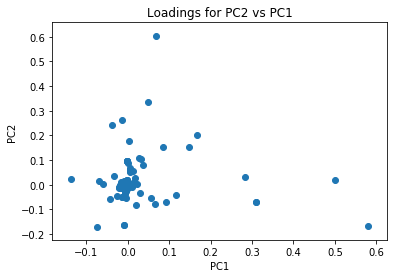

In [7]:
%matplotlib inline

pc1 = pipe_pca.stages[-1].pc.toArray()[:, 0].tolist()
pc2 = pipe_pca.stages[-1].pc.toArray()[:, 1].tolist()

plt.scatter(pc1, pc2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Loadings for PC2 vs PC1')

plt.show()

##### Grading Feedback Cell

# Question 4 (10 pts)

Create two Pandas dataframes `pc1_pd` and `pc2_pd` with the columns `word` and `abs_loading` that contain the top 5 words and absolute loadings for the principal components 1 and 2, respetively.  Print both dataframes. Interpret the loadings.

In [8]:
vocabulary = pipe_features.stages[2].vocabulary

pc1_pd = pd.DataFrame([vocabulary, pc1]).T.rename(columns = {0: 'word', 1: 'abs_loading'})
pc1_pd.abs_loading = pc1_pd.abs_loading.abs()
pc1_pd = pc1_pd.sort_values('abs_loading', ascending = False).head()

pc2_pd = pd.DataFrame([vocabulary, pc2]).T.rename(columns = {0: 'word', 1: 'abs_loading'})
pc2_pd.abs_loading = pc2_pd.abs_loading.abs()
pc2_pd = pc2_pd.sort_values('abs_loading', ascending = False).head()

print("Top 5 words with absolute loading for PC1")

display(pc1_pd)

print("\nTop 5 words with absolute loading for PC2")

display(pc2_pd)

Top 5 words with absolute loading for PC1


,word,abs_loading
16,computational,0.580729
14,sciences,0.499646
37,"physics,",0.308371
35,"astronomy,",0.308371
21,school,0.28337



Top 5 words with absolute loading for PC2


,word,abs_loading
7,information,0.604629
19,computing,0.336743
18,systems,0.262752
12,management,0.240699
22,informatics,0.200191


##### Grading Feedback Cell

Your interpretation here (5 pts): 

- 'computational' and 'sciences'are highly correlated to PC1. 

- Correlation of 'physics', 'astronomy' and 'school' with PC1 is hard to interpret as their absolute loadings are less than 0.5.

- 'information' is highly correlated to PC2.

- Correlation of 'computing', 'systems', 'management' and 'informatics' with PC2 is hard to interpret as their absolute loadings are less than 0.5.

##### Grading Feedback Cell

# Question 5: (10 pts)

Create a new pipeline for PCA called `pipe_pca2` where you fit 50 principal components. Extract the `PCAModel` from the stages of this pipeline, and assign to a variable named `explainedVariance` which represents the variance explained by components of the model. Finally, assign to a variable named `best_k` the value $k$ such that ($k+1$)-th component is not able to explain more than 0.01 variance. You can use a for-loop to find such best k.  The value best_k should be be 0 based - in other words present best_k assuming that you started counting at 0.

In [9]:
pca = PCA(k = 50, inputCol ='centered_features', outputCol = 'scores')

pipe_pca2 = Pipeline(stages = [tokenizer, sw_filter, cv, idf, center, pca]).fit(ds_programs_text_df)

PCAModel = pipe_pca2.stages[-1]

explainedVariance = PCAModel.explainedVariance

for i in range(len(explainedVariance)):
    
    if explainedVariance[i + 1] < 0.01:
        best_k = i
        break

print("Best value of k:", best_k)

Best value of k: 30


##### Grading Feedback Cell

# Question 6: (10 pts)

Create a new pipeline for PCA called pipe_pca3 (similar to pipe_pca2 above) where you fit the maximum possible number of principal components for this dataset. Create a scree plot and a plot of cumulative variance explained.

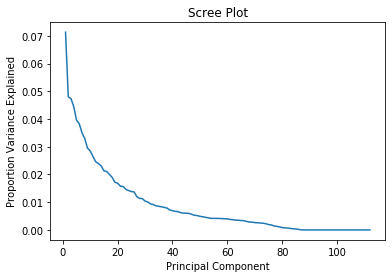

In [10]:
%matplotlib inline

pca = PCA(k = len(vocabulary), inputCol ='centered_features', outputCol = 'scores')

pipe_pca3 = Pipeline(stages = [tokenizer, sw_filter, cv, idf, center, pca]).fit(ds_programs_text_df)

explained_var = pipe_pca3.stages[-1].explainedVariance

plt.plot(np.arange(1, len(explained_var) + 1), explained_var)
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")
plt.title("Scree Plot")

plt.show()

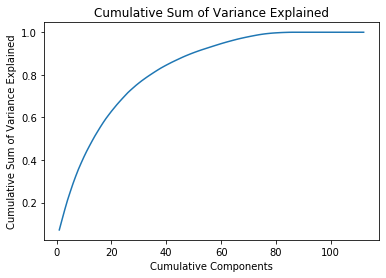

In [11]:
%matplotlib inline

cum_sum = np.cumsum(explained_var)

plt.plot(np.arange(1, len(explained_var) + 1), cum_sum)
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

plt.show()

##### Grading Feedback Cell

# Question 7: (10 pts)
Create a pipeline named pipe_pca4 (similar to pipe_pca3 above) that computes the first 2 principal components.  Add a kmeans objects to the end of pipe_pca4 and compute kmeans with k = 5.  Create a scatter plot PC2 vs. PC1 where each scatter dot is colored by the cluster assignment.  Include a plot legend.

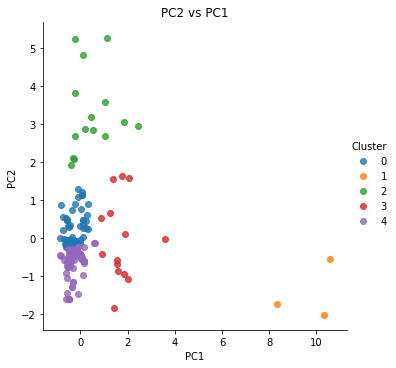

In [12]:
%matplotlib inline

pca = PCA(k = 2, inputCol ='centered_features', outputCol = 'scores')

kmeans = KMeans(k = 5, featuresCol = 'scores', predictionCol = 'kmeans_feat')

pipe_pca4 = Pipeline(stages = [tokenizer, sw_filter, cv, idf, center, pca, kmeans]).fit(ds_programs_text_df)

pc = np.array(pipe_pca4.transform(ds_programs_text_df).select('scores').rdd.map(lambda x: x['scores']).collect())

cluster = np.array(pipe_pca4.transform(ds_programs_text_df).select('kmeans_feat').rdd.map(lambda x: x['kmeans_feat']).collect())

km = pd.DataFrame([pc[:, 0], pc[:, 1], cluster]).T.rename(columns = {0: 'PC1', 1: 'PC2', 2: 'Cluster'})
km.Cluster = km.Cluster.astype(int)

sns.lmplot(data = km, x = 'PC1', y = 'PC2', hue = 'Cluster', fit_reg = False, legend = True, legend_out = True).set(title = 'PC2 vs PC1')

plt.show()

##### Grading Feedback Cell

# Question 8: (10 pts)
Starting with pipe_pca2, transform the pipeline and save the resulting dataframe to a variable named `pca_fun`.  Extract the output from the standard scaler column from the first row of pca_fun and store in a variable called `z`. Manually compute 10 PCA scores by projecting z onto the first 10 loading vectors. Save the 10 projected pca scores in a varialbe called `projection`.  Extract the first 10 PCA scores from the first row of pca_fun and save them in a variable named `model_scores`.  Print `projection` and `model_scores`.  Compare `projection` to `model_scores` and explain why they are the same or different. 

In [13]:
pca_fun = pipe_pca2.transform(ds_programs_text_df)

z = pca_fun.select('centered_features', 'scores').first()['centered_features']

loadings = pipe_pca2.stages[5].pc.toArray()

projection = z.dot(loadings[:, : 10])

print("10 PCA manually computed:", projection)

model_scores = pca_fun.select('centered_features', 'scores').first()['scores'][: 10]

print("\n10 PCA extracted from the model:", model_scores)

10 PCA manually computed: [-0.26874416 -0.43443022 -1.99990463 -0.45846524  0.14171739 -0.78124129
 -1.46182952 -0.38379532  0.01341778 -0.24463091]

10 PCA extracted from the model: [-0.26874416 -0.43443022 -1.99990463 -0.45846524  0.14171739 -0.78124129
 -1.46182952 -0.38379532  0.01341778 -0.24463091]


##### Grading Feedback Cell

Your explanation here (5 pts): 

The scores are produced by projecting the data observations onto the loading vectors. A projection is performed by multiplying the loading vector by the data observations which projects the observation in the direction of the loading vector. Hence, both "projection" and "model_scores" are the same.

##### Grading Feedback Cell

# Question 9: (10 pts)
Using PCA loading vectors, perform an inverse transform on the `projection` variable and store the result in a variable named inverse.  Print `inverse` and the original `z` data.  Explain why the inverse data is the same as `z` (or really close to `z`), or why it is different than `z`.  

In [14]:
inverse = loadings[:, : 10].dot(projection)
    
print("Inverse:", inverse[: 10])

print("\nz:", z[:10])

Inverse: [-0.0398181   0.24320586 -0.63158572 -0.26995935  0.33956369  0.12125008
  2.06481351 -0.25114705 -0.39096829  0.00739924]

z: [ 0.05718022  0.30526264 -0.4954898  -0.36295505  0.8641986  -0.24098572
  2.21867819 -0.23897148 -0.21909331 -0.20638446]


##### Grading Feedback Cell

Your explanation here (5 pts): 

The "inverse" values are quite different compared to the actual "z" value as we are using only the first 10 loadings to calculate the inverse transform. The more loadings we use for the inverse transform, the closer the approximation to the original z.

##### Grading Feedbck Cell

# Question 10: (10 pts)

Think about the cumulative variance and the scree plot from the question above.  If you were building a machine learning model, how many principal components would you pick for your model.  Explain why.  

Your Answer Here:

Deciding on number of principal components to use for building a machine learning model is not a simple task. The scree plot can be used to decide on number of principal components by looking for an elbow in the plot. The cumulative variance plot can be used to determine how much of variance is explanied by the number of principal components selected from the scree plot.

##### Grading Feedback Cell